<a href="https://colab.research.google.com/github/byronkamal/data_science/blob/master/dog_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Config Inicial

In [22]:
# instalar libs
# após a instalação das libs, reinicie o ambiente de execução (Restart Runtime)

!pip install -Uqq fastbook
!pip install streamlit

# as libs abaixos servem para o correto funcionamento do Streamlit
!pip install ipykernel>=5.1.2
!pip install pydeck

In [2]:
# importar libs

import fastbook
fastbook.setup_book()

from fastbook import *
from fastai.vision.widgets import *
from pathlib import Path

2021-08-25 04:07:47.338 INFO    numexpr.utils: NumExpr defaulting to 2 threads.


In [3]:
# Adicionar chave - Bing Search Image API
key = os.environ.get('AZURE_SEARCH_KEY', '0617324778974dd7a2bc4b4b00ce6cda')

In [19]:
# buscar imagens do dog salsicha (winner dog)
results = search_images_bing(key, 'winner dog')
ims = results.attrgot('content_url')
len(ims)

150

## Trabalhando com dados e o modelo

In [5]:
# outros tipos de dogs
dog_types = 'Winner','Chihuahua','Basset Hound'
path = Path('dogs')

if not path.exists():
    path.mkdir()
    for o in dog_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} dog')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [6]:
# buscar imagens dos dogs
fns = get_image_files(path)

In [7]:
# retirar imagens que apresentem algum tipo ruído ou problema
failed = verify_images(fns)
failed.map(Path.unlink);

In [8]:
#construção do DataBlock
dogs = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=1),
    get_y=parent_label,
    item_tfms=Resize(128))
    
dls = dogs.dataloaders(path)

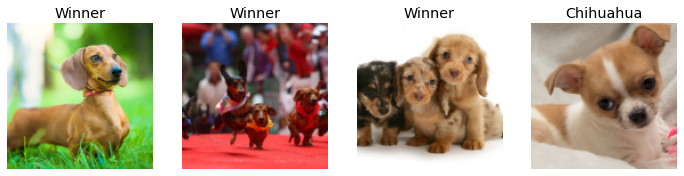

In [9]:
dls.valid.show_batch(max_n=4, nrows=1)

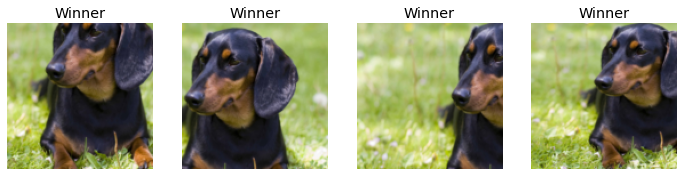

In [10]:
dogs = dogs.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = dogs.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


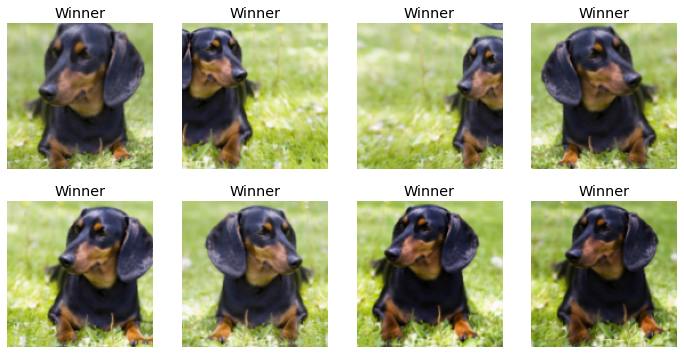

In [11]:
dogs = dogs.new(item_tfms=Resize(128), batch_tfms=aug_transforms())
dls = dogs.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [13]:
dogs = dogs.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = dogs.dataloaders(path)

In [13]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


## Execução do app

In [ ]:
learn.export('dog.pkl')

In [14]:
path = Path()
learn_inf = load_learner(path/'dog.pkl')

In [15]:
# %%writefile app.py
import streamlit as st

class Predict:
    def __init__(self, filename):
        self.learn_inference = load_learner(Path()/filename)
        self.img = self.get_image_from_upload()
        if self.img is not None:
            self.display_output()
            self.get_prediction()
    
    @staticmethod
    def get_image_from_upload():
        uploaded_file = st.file_uploader("Upload Files",type=['png','jpeg', 'jpg'])
        if uploaded_file is not None:
            return PILImage.create((uploaded_file))
        return None

    def display_output(self):
        st.image(self.img.to_thumb(500,500), caption='Uploaded Image')

    def get_prediction(self):

        if st.button('Classify'):
            pred, pred_idx, probs = self.learn_inference.predict(self.img)
            st.write(f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}')
        else: 
            st.write(f'Click the button to classify') 

if __name__=='__main__':

    file_name='dog.pkl'

    predictor = Predict(file_name)

2021-08-25 04:13:49.427 
  command:

    streamlit run /usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py [ARGUMENTS]
